# <b> <code> Mohammad Sohail </code></b>

# <b><code>GRIP-JAN-23_TASK_07</code></b>





## <b> Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines </b>
  

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Importing necessary laibraries

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

import yfinance as yf
import zipfile


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# importing data set

In [ ]:
# open zipped dataset
with zipfile.ZipFile("/content/drive/MyDrive/GRIP23_TASKS/india-news-headlines.zip") as z:
   # open the csv file in the dataset
   with z.open("india-news-headlines.csv") as f:
       
      # read the dataset
      news = pd.read_csv(f)
       
      # display dataset
      print(news.head())

   publish_date headline_category  \
0      20010102           unknown   
1      20010102           unknown   
2      20010102           unknown   
3      20010102           unknown   
4      20010102           unknown   

                                       headline_text  
0  Status quo will not be disturbed at Ayodhya; s...  
1                Fissures in Hurriyat over Pak visit  
2              America's unwanted heading for India?  
3                 For bigwigs; it is destination Goa  
4               Extra buses to clear tourist traffic  


In [ ]:
news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [ ]:
news.tail()

,publish_date,headline_category,headline_text
3650965,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...
3650969,20220331,city.salem,Tamil Nadu sees marginal rise of Covid cases w...


In [ ]:
news.shape

(3650970, 3)

* the data of news headline between 2001 to 2022 this data is 22 yars of data 

# news headline data  date range is between 2001 to 2022 so we can import data between these year

In [ ]:
bse_data = yf.download('^BSESN', start='2000-12-31', end='2022-04-01')


[*********************100%***********************]  1 of 1 completed


In [ ]:
bse_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [ ]:
bse_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300
2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100
2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300
2022-03-31,58779.710938,58890.921875,58485.789062,58568.511719,58568.511719,4400


In [ ]:
bse_data.shape

(5235, 6)

In [ ]:
bse_data.reset_index(inplace=True)


In [ ]:
#Converting Date column to datetime datatype
bse_data['Date'] = pd.to_datetime(bse_data['Date'])
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5235 entries, 0 to 5234
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5235 non-null   datetime64[ns]
 1   Open       5235 non-null   float64       
 2   High       5235 non-null   float64       
 3   Low        5235 non-null   float64       
 4   Close      5235 non-null   float64       
 5   Adj Close  5235 non-null   float64       
 6   Volume     5235 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 286.4 KB


In [ ]:
#droping Nan Values
bse_data.dropna(inplace=True)

Text(0, 0.5, 'Close')

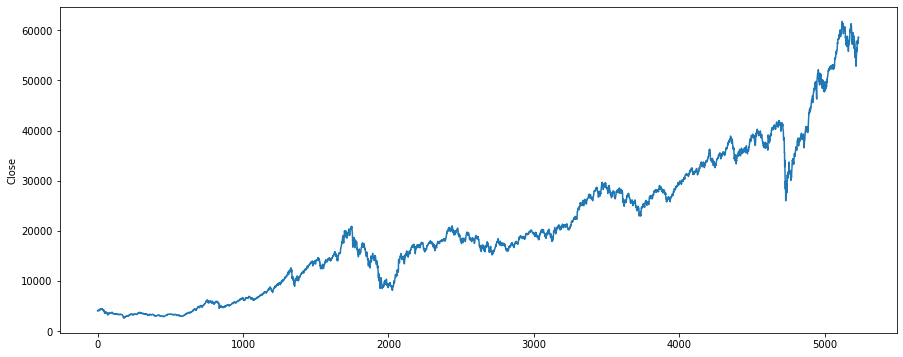

In [ ]:
plt.figure(figsize=(15, 6))
bse_data['Close'].plot()
plt.ylabel('Close')

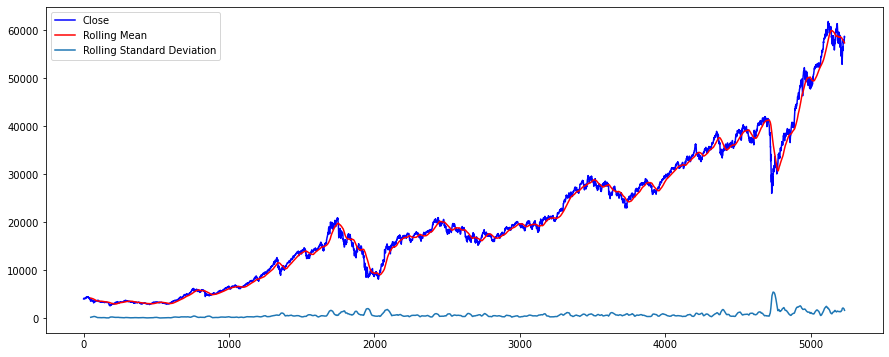

In [ ]:
#Plotting moving average
close = bse_data['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(15, 6))
bse_data['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

In [ ]:
# creating function to showing weekly moving avarages
def stock_weekmovingavg(wks, df):
  dateclose_data = pd.DataFrame({'Date': df['Date'], 'Close':df['Close']})
  dateclose_data.set_index('Date', inplace=True)
  num = wks * 5                                 #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
  dateclose_data['movingavg'] = dateclose_data['Close'].rolling(window=num).mean().shift()
  return dateclose_data.dropna()

In [ ]:
stock_weekmovingavg(4, bse_data).head()


,Close,movingavg
Date,,
2001-01-31,4326.720215,4153.535486
2001-02-01,4286.109863,4168.927502
2001-02-02,4352.259766,4180.231995
2001-02-05,4370.470215,4192.076477
2001-02-06,4375.290039,4201.413489


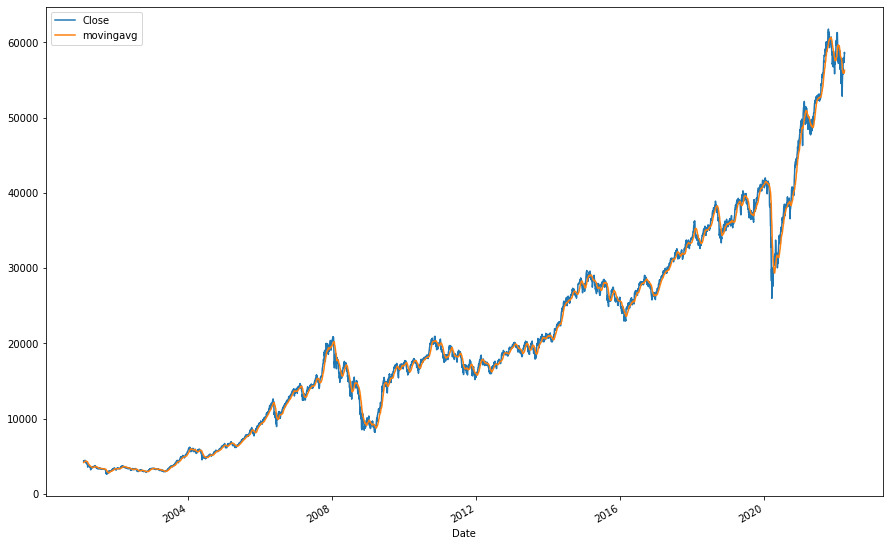

In [ ]:
stock_weekmovingavg(4, bse_data).plot(figsize=(15, 10))


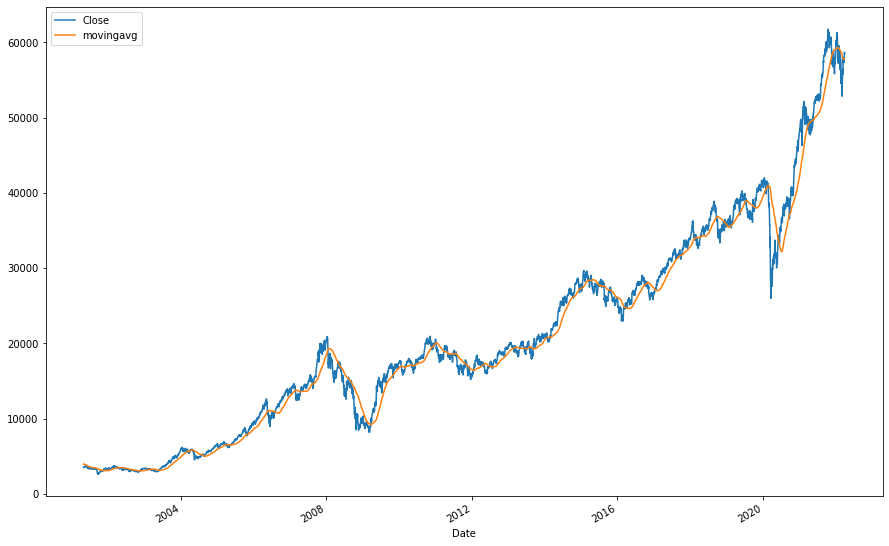

In [ ]:
stock_weekmovingavg(16, bse_data).plot(figsize=(15, 10))
plt.show()

Text(0.5, 1.0, 'Returns')

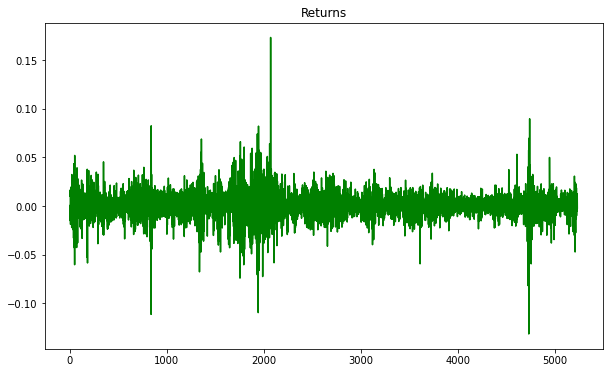

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

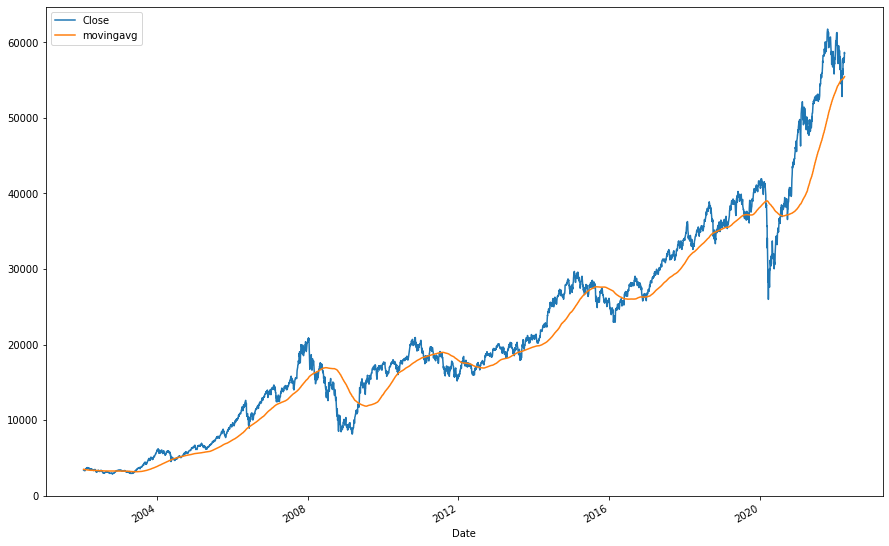

In [ ]:
stock_weekmovingavg(52, bse_data).plot(figsize=(15, 10))
plt.show()

In [ ]:
train = bse_data[:3000]
test = bse_data[3000:]

In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

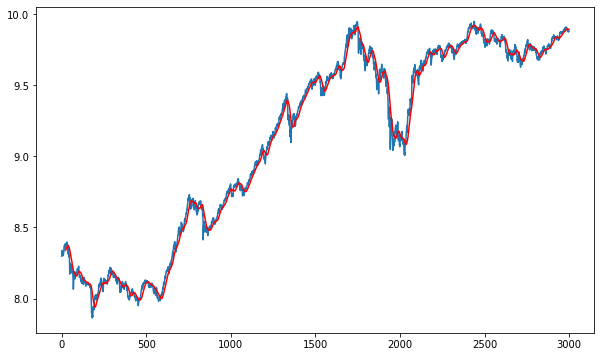

In [ ]:
mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16297.097, Time=1.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16274.785, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16292.168, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16294.337, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16273.551, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16298.603, Time=1.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16298.833, Time=2.83 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16299.388, Time=2.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16297.525, Time=2.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-16297.548, Time=0.91 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-16295.289, Time=1.77 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-16298.171, Time=1.54 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 16.447 seconds


Text(0, 0.5, 'Actual Stock Price')

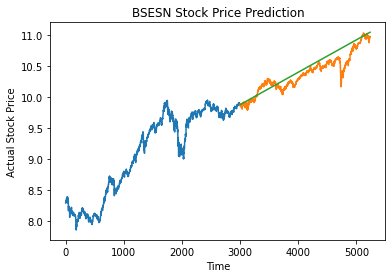

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

### Textual Analysis of news from Times of India News Headlines¶


In [ ]:
news

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
3650965,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [ ]:
#converting publish_date column to 
news['publish_date'] = pd.to_datetime(news['publish_date'], format = '%Y%m%d')

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 83.6+ MB


In [ ]:
news['headline_category'].unique()


array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [ ]:
#checking all the values count (unique values total count)
news['headline_category'].value_counts()


india                                                    297491
unknown                                                  209583
city.mumbai                                              150451
city.delhi                                               137648
business.india-business                                  121195
                                                          ...  
nepal-india-earthquake.opinion                                8
elections.lok-sabha-elections-2019.tripura.news               8
best-products.home-decor-and-garden.living-room-decor         8
profiles.india-profiles                                       8
pms-us-visit                                                  8
Name: headline_category, Length: 1041, dtype: int64

In [ ]:
#checking all the values count (unique values total count)
news['headline_text'].value_counts()

Straight Answers                                                                                                          6723
Cartoons                                                                                                                  1536
Straight answers                                                                                                          1500
Photogallery                                                                                                              1353
Your say                                                                                                                  1012
                                                                                                                          ... 
Pak President Asif Ali Zardari at 7RCR; meets Manmohan Singh                                                                 1
Why Goa Inc is so happy with CM Manohar Parrikar                                                               

In [ ]:
news[news.duplicated(keep=False)]


,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic
...,...,...,...
3646409,2022-03-22,city.hubballi,BJP divided over probable induction of Basavar...
3648504,2022-03-27,city.chennai,Father; daughter killed in TN as e-bike on cha...
3648598,2022-03-27,city.chennai,Father; daughter killed in TN as e-bike on cha...
3649619,2022-03-29,city.hyderabad,Telangana logs 30 new Covid cases


In [ ]:
news.loc[news['headline_category']=='entertainment.hindi.bollywood']

,publish_date,headline_category,headline_text
85,2001-01-02,entertainment.hindi.bollywood,Raju Chacha
126,2001-01-03,entertainment.hindi.bollywood,'Devdas': Jinxed?
3108,2001-04-09,entertainment.hindi.bollywood,One Two Ka Four
3151,2001-04-09,entertainment.hindi.bollywood,Chhupa Rustam
3739,2001-04-27,entertainment.hindi.bollywood,Pyaar Tune Kya Kiya
...,...,...,...
3648994,2022-03-28,entertainment.hindi.bollywood,Exclusive! Kareena Kapoor Khan's younger son J...
3649472,2022-03-29,entertainment.hindi.bollywood,Bobby Deol: Like my dad; I hope to be working ...
3649489,2022-03-29,entertainment.hindi.bollywood,Kangana Ranaut reacts to Will Smith's slapping...
3650484,2022-03-31,entertainment.hindi.bollywood,Jackie Shroff rushes to Pune to mourn the deat...


In [ ]:
news


,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic
...,...,...,...
3650965,2022-03-31,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,2022-03-31,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,2022-03-31,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,2022-03-31,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [ ]:
#getting a list of unique dates in publish_date column
lst = news['publish_date'].value_counts().index.tolist()

In [ ]:
new = []
for x in lst:
  df = news.loc[news['publish_date'] == x]
  headlinetext = ''
  publishdate = str(x)
  headlinetext = df['headline_text'].iloc[0]
  for i in range(1 , len(df)):
    headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
  new.append(headlinetext)

In [ ]:
#creating a new dataset
news_df = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

In [ ]:
news_df

,publish_date,headline_text
0,2014-12-21,ABC to CEO. Indian wholegrains you must not ig...
1,2014-12-15,Restaurant review: Via Milano (Italian). Recip...
2,2014-10-10,Inactive moms turn kids into couch potatoes. D...
3,2014-10-11,Get that perfect 10 figure in two weeks. Recip...
4,2014-11-09,Are you in an unhealthy relationship?. In pics...
...,...,...
7712,2001-06-05,Darkness Triumphs
7713,2001-03-05,The Buddha Smiles
7714,2001-06-04,Aamir Khan: The taxman cometh!
7715,2001-03-02,Such A Long Journey


In [ ]:
#sorting the dataset based on dates
news_df.sort_values(by='publish_date', inplace=True, ignore_index=True)

In [ ]:
news_df.head()

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark. Thin...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...


In [ ]:
#Cleaning headlines
c = []
for i in range(0,len(news_df['headline_text'])):
    news1 = re.sub('[^a-zA-Z]',' ',news_df['headline_text'][i])
    news1 = news1.lower()
    news1 = news1.split()
    news1 = [word for word in news1 if not word in set(stopwords.words('english'))]
    news1=' '.join(news1)
    c.append(news1)

In [ ]:
news_df['News'] = pd.Series(c)
news_df

,publish_date,headline_text,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,status quo disturbed ayodhya says vajpayee fis...
1,2001-01-03,Powerless north India gropes in the dark. Thin...,powerless north india gropes dark think laxman...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,string pulled stephen hawking india vajpayee g...
3,2001-01-05,Light combat craft takes India into club class...,light combat craft takes india club class hawk...
4,2001-01-06,Light combat craft takes India into club class...,light combat craft takes india club class hawk...
...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,playing dead man body god meant sitting refrig...
7713,2022-03-28,As fashion becomes democratic; demand for styl...,fashion becomes democratic demand stylists soa...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...,bobby deol like dad hope working age yashas su...
7715,2022-03-30,I will not give in to trends: Dossmode. The ti...,give trends dossmode time gave boyfriend incre...


In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
news_df['Subjectivity'] = news_df['News'].apply(getSubjectivity)
news_df['Polarity'] = news_df['News'].apply(getPolarity)
news_df

,publish_date,headline_text,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,status quo disturbed ayodhya says vajpayee fis...,0.269097,0.113889
1,2001-01-03,Powerless north India gropes in the dark. Thin...,powerless north india gropes dark think laxman...,0.415385,0.111538
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,string pulled stephen hawking india vajpayee g...,0.440650,0.057956
3,2001-01-05,Light combat craft takes India into club class...,light combat craft takes india club class hawk...,0.481766,0.268495
4,2001-01-06,Light combat craft takes India into club class...,light combat craft takes india club class hawk...,0.439394,0.248485
...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,playing dead man body god meant sitting refrig...,0.352840,0.033765
7713,2022-03-28,As fashion becomes democratic; demand for styl...,fashion becomes democratic demand stylists soa...,0.369710,0.054588
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...,bobby deol like dad hope working age yashas su...,0.395617,0.083869
7715,2022-03-30,I will not give in to trends: Dossmode. The ti...,give trends dossmode time gave boyfriend incre...,0.332417,0.028054


In [ ]:
plt.figure(figsize = (10,6))
news_df['Polarity'].hist(color = 'purple')

In [ ]:
plt.figure(figsize = (10,6))
news_df['Subjectivity'].hist(color = 'blue')

In [ ]:
sia = SentimentIntensityAnalyzer()

news_df['Compound'] = [sia.polarity_scores(v)['compound'] for v in news_df['News']]
news_df['Negative'] = [sia.polarity_scores(v)['neg'] for v in news_df['News']]
news_df['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news_df['News']]
news_df['Positive'] = [sia.polarity_scores(v)['pos'] for v in news_df['News']]
news_df

,publish_date,headline_text,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,status quo disturbed ayodhya says vajpayee fis...,0.269097,0.113889,-0.9662,0.164,0.735,0.101
1,2001-01-03,Powerless north India gropes in the dark. Thin...,powerless north india gropes dark think laxman...,0.415385,0.111538,-0.7184,0.173,0.686,0.141
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,string pulled stephen hawking india vajpayee g...,0.440650,0.057956,0.4019,0.127,0.748,0.125
3,2001-01-05,Light combat craft takes India into club class...,light combat craft takes india club class hawk...,0.481766,0.268495,0.9726,0.167,0.637,0.197
4,2001-01-06,Light combat craft takes India into club class...,light combat craft takes india club class hawk...,0.439394,0.248485,-0.8316,0.231,0.628,0.142
...,...,...,...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,playing dead man body god meant sitting refrig...,0.352840,0.033765,-0.9999,0.163,0.749,0.088
7713,2022-03-28,As fashion becomes democratic; demand for styl...,fashion becomes democratic demand stylists soa...,0.369710,0.054588,-0.9997,0.155,0.742,0.104
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...,bobby deol like dad hope working age yashas su...,0.395617,0.083869,-0.9997,0.150,0.759,0.091
7715,2022-03-30,I will not give in to trends: Dossmode. The ti...,give trends dossmode time gave boyfriend incre...,0.332417,0.028054,-0.9998,0.162,0.751,0.087


In [ ]:
news_df.rename(columns = {'publish_date':'Date'}, inplace = True)


In [ ]:
news_df.to_csv("/content/drive/MyDrive/GRIP23_TASKS/news_sentiment_analysis.csv")

In [ ]:
bse_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0
...,...,...,...,...,...,...,...
5230,2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900
5231,2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300
5232,2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100
5233,2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300


In [ ]:

# creating variable moving avarages
bse_data['movingavg16weeks'] = round(bse_data['Close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
bse_data['movingavg52weeks'] = round(bse_data['Close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
bse_data['movingavg15days'] = round(bse_data['Close'].rolling(window = 15, min_periods = 1).mean().shift(),2)  
bse_data['movingavg50days'] = round(bse_data['Close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
bse_data['movingavg100days'] = round(bse_data['Close'].rolling(window = 100, min_periods = 1).mean().shift(),2)
bse_data['movingavg200days'] = round(bse_data['Close'].rolling(window = 200, min_periods = 1).mean().shift(),2)

bse_data['price'] = round((bse_data['High'] + bse_data['Low'] + bse_data['Close']) / 3 , 2)
bse_data['Close'] = round(bse_data['Close'] , 2)

In [ ]:
bse_data

,Date,Open,High,Low,Close,Adj Close,Volume,movingavg16weeks,movingavg52weeks,movingavg15days,movingavg50days,movingavg100days,movingavg200days,price
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.88,4018.879883,0,NaN,NaN,NaN,NaN,NaN,NaN,3992.27
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.02,4060.020020,0,4018.88,4018.88,4018.88,4018.88,4018.88,4018.88,4035.09
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.37,4115.370117,0,4039.45,4039.45,4039.45,4039.45,4039.45,4039.45,4135.30
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.73,4183.729980,0,4064.76,4064.76,4064.76,4064.76,4064.76,4064.76,4164.70
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.43,4120.430176,0,4094.50,4094.50,4094.50,4094.50,4094.50,4094.50,4142.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,2022-03-25,57801.718750,57845.371094,57100.238281,57362.20,57362.199219,6900,57791.77,55358.69,55924.74,57620.41,58139.13,57043.44,57435.94
5231,2022-03-28,57472.718750,57638.339844,56825.089844,57593.49,57593.488281,6300,57795.49,55383.75,56075.37,57555.32,58119.69,57068.61,57352.31
5232,2022-03-29,57814.761719,58001.531250,57639.351562,57943.65,57943.648438,12100,57794.35,55411.40,56292.69,57484.19,58094.24,57095.20,57861.51
5233,2022-03-30,58362.851562,58727.781250,58176.000000,58683.99,58683.988281,6300,57787.88,55440.25,56632.75,57418.36,58073.38,57125.21,58529.26


In [ ]:
#fill  the null columns
bse_data.fillna(method = 'bfill', inplace = True)
bse_data.fillna(method = 'ffill', inplace = True)

In [ ]:
#merging dataframe 
df_merge = pd.merge(bse_data, news_df, how='inner', on='Date')


In [ ]:
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,movingavg16weeks,movingavg52weeks,movingavg15days,...,movingavg200days,price,headline_text,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.88,4018.879883,0,4018.88,4018.88,4018.88,...,4018.88,3992.27,Status quo will not be disturbed at Ayodhya; s...,status quo disturbed ayodhya says vajpayee fis...,0.269097,0.113889,-0.9662,0.164,0.735,0.101
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.02,4060.020020,0,4018.88,4018.88,4018.88,...,4018.88,4035.09,Powerless north India gropes in the dark. Thin...,powerless north india gropes dark think laxman...,0.415385,0.111538,-0.7184,0.173,0.686,0.141
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.37,4115.370117,0,4039.45,4039.45,4039.45,...,4039.45,4135.30,The string that pulled Stephen Hawking to Indi...,string pulled stephen hawking india vajpayee g...,0.440650,0.057956,0.4019,0.127,0.748,0.125
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.73,4183.729980,0,4064.76,4064.76,4064.76,...,4064.76,4164.70,Light combat craft takes India into club class...,light combat craft takes india club class hawk...,0.481766,0.268495,0.9726,0.167,0.637,0.197
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.43,4120.430176,0,4094.50,4094.50,4094.50,...,4094.50,4142.89,Sangh Parivar; Babri panel up the ante. Frontr...,sangh parivar babri panel ante frontrunner key...,0.389270,-0.031037,-0.9709,0.151,0.759,0.090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5201,2022-03-25,57801.718750,57845.371094,57100.238281,57362.20,57362.199219,6900,57791.77,55358.69,55924.74,...,57043.44,57435.94,Speeding up; shortcuts and tackling unruly cus...,speeding shortcuts tackling unruly customers t...,0.361138,-0.017290,-0.9999,0.177,0.745,0.078
5202,2022-03-28,57472.718750,57638.339844,56825.089844,57593.49,57593.488281,6300,57795.49,55383.75,56075.37,...,57068.61,57352.31,As fashion becomes democratic; demand for styl...,fashion becomes democratic demand stylists soa...,0.369710,0.054588,-0.9997,0.155,0.742,0.104
5203,2022-03-29,57814.761719,58001.531250,57639.351562,57943.65,57943.648438,12100,57794.35,55411.40,56292.69,...,57095.20,57861.51,Bobby Deol: Like my dad; I hope to be working ...,bobby deol like dad hope working age yashas su...,0.395617,0.083869,-0.9997,0.150,0.759,0.091
5204,2022-03-30,58362.851562,58727.781250,58176.000000,58683.99,58683.988281,6300,57787.88,55440.25,56632.75,...,57125.21,58529.26,I will not give in to trends: Dossmode. The ti...,give trends dossmode time gave boyfriend incre...,0.332417,0.028054,-0.9998,0.162,0.751,0.087


In [ ]:
df_merge.to_csv('/content/drive/MyDrive/GRIP23_TASKS/stock_news.csv')

In [ ]:
df_merge=pd.read_csv('/content/drive/MyDrive/GRIP23_TASKS/stock_news.csv')

In [ ]:
df_merge

In [ ]:
df_merge.columns


Index(['Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'movingavg16weeks', 'movingavg52weeks', 'movingavg15days',
       'movingavg50days', 'movingavg100days', 'movingavg200days', 'price',
       'headline_text', 'News', 'Subjectivity', 'Polarity', 'Compound',
       'Negative', 'Neutral', 'Positive'],
      dtype='object')

In [ ]:
# creating Final Data frame to prediction
final_df=df_merge.filter(['Close','movingavg16weeks','movingavg52weeks','movingavg15days','movingavg50days','movingavg200days',
                          'Subjectivity','Polarity','Compound','Negative','Neutral','Positive'])

In [ ]:
final_df

,Close,movingavg16weeks,movingavg52weeks,movingavg15days,movingavg50days,movingavg200days,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4018.88,4018.88,4018.88,4018.88,4018.88,4018.88,0.269097,0.113889,-0.9662,0.164,0.735,0.101
1,4060.02,4018.88,4018.88,4018.88,4018.88,4018.88,0.415385,0.111538,-0.7184,0.173,0.686,0.141
2,4115.37,4039.45,4039.45,4039.45,4039.45,4039.45,0.440650,0.057956,0.4019,0.127,0.748,0.125
3,4183.73,4064.76,4064.76,4064.76,4064.76,4064.76,0.481766,0.268495,0.9726,0.167,0.637,0.197
4,4120.43,4094.50,4094.50,4094.50,4094.50,4094.50,0.389270,-0.031037,-0.9709,0.151,0.759,0.090
...,...,...,...,...,...,...,...,...,...,...,...,...
5201,57362.20,57791.77,55358.69,55924.74,57620.41,57043.44,0.361138,-0.017290,-0.9999,0.177,0.745,0.078
5202,57593.49,57795.49,55383.75,56075.37,57555.32,57068.61,0.369710,0.054588,-0.9997,0.155,0.742,0.104
5203,57943.65,57794.35,55411.40,56292.69,57484.19,57095.20,0.395617,0.083869,-0.9997,0.150,0.759,0.091
5204,58683.99,57787.88,55440.25,56632.75,57418.36,57125.21,0.332417,0.028054,-0.9998,0.162,0.751,0.087


In [ ]:
# scaling the values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
scale_df = pd.DataFrame(sc.fit_transform(final_df))
scale_df.columns = final_df.columns
scale_df.index = final_df.index
scale_df.head()

,Close,movingavg16weeks,movingavg52weeks,movingavg15days,movingavg50days,movingavg200days,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.023980,0.017677,0.016603,0.022124,0.018824,0.016491,0.269097,0.485185,0.016901,0.369369,0.735,0.133598
1,0.024675,0.017677,0.016603,0.022124,0.018824,0.016491,0.415385,0.482051,0.140807,0.389640,0.686,0.186508
2,0.025610,0.018043,0.016996,0.022478,0.019185,0.016872,0.440650,0.410609,0.700985,0.286036,0.748,0.165344
3,0.026766,0.018492,0.017480,0.022914,0.019629,0.017340,0.481766,0.691327,0.986349,0.376126,0.637,0.260582
4,0.025696,0.019020,0.018048,0.023426,0.020152,0.017891,0.389270,0.291951,0.014551,0.340090,0.759,0.119048


In [ ]:
#separating the predicted date row from main dataset after getting all the calculated average values
train_bsedata = scale_df.iloc[:3500,:].reset_index()  
test_bsedata = scale_df.iloc[3500:,:].reset_index()  

In [ ]:
X = train_bsedata.drop(['Close'], axis = 1)
y = train_bsedata[['Close']]

In [ ]:
#splitting the data 80/20 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(2800, 12)

In [ ]:
from sklearn.metrics import mean_absolute_error


# use randome forest algorithm

In [ ]:
rfg = RandomForestRegressor(random_state = 42, n_estimators = 500, criterion='mse', max_depth = 30, min_samples_leaf=2, min_samples_split=5, n_jobs=1)
rfg.fit(x_train, y_train)
prediction=rfg.predict(x_test)
print(f"R2 score of randome forest : {r2_score(prediction,y_test)}")
print(f"Means Sqr of randome forest : {mean_squared_error(prediction,y_test)}")
print(f"MAPE OF RANDOME FOREST: {mean_absolute_error(prediction,y_test)}")




R2 score of randome forest : 0.9986480651429333
Means Sqr of randome forest : 2.05285851032059e-05
MAPE OF RANDOME FOREST: 0.0030163315739075505


In [ ]:
#Preparing Extra Tree Regression
from sklearn.ensemble import  ExtraTreesRegressor
ET_Model=ExtraTreesRegressor(n_estimators = 120)
ET_Model.fit(x_train,y_train)
ET_pred=ET_Model.predict(x_test)
print(f"R2 score of extra tree : {r2_score(ET_pred,y_test)}")
print(f"Means Sqr of EXTRA TREE : {mean_squared_error(ET_pred,y_test)}")
print(f"MAPE OF EXTRA TREE: {mean_absolute_error(ET_pred,y_test)}")

R2 score of extra tree : 0.999176623944031
Means Sqr of EXTRA TREE : 1.2518927068493776e-05
MAPE OF EXTRA TREE: 0.0023658702871793237


In [ ]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor()
lgb_model.fit(x_train,y_train)
lgb_pred=lgb_model.predict(x_test)


print(f"R2 score of LGMB : {r2_score(lgb_pred,y_test)}")
print(f"Means Sqr of LGMB : {mean_squared_error(lgb_pred,y_test)}")
print(f"MAPE OF LGMB: {mean_absolute_error(lgb_pred,y_test)}")


R2 score of LGMB : 0.9982282331729211
Means Sqr of LGMB : 2.687614911979034e-05
MAPE OF LGMB: 0.0035914003205112137


## use adaboost

In [ ]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
adv_pred = adb.predict(x_test)

print(f"R2 score of ADA BOOST : {r2_score(adv_pred,y_test)}")
print(f"Means Sqr of ADA BOOST : {mean_squared_error(adv_pred,y_test)}")
print(f"MAPE OF ADA BOOST: {mean_absolute_error(adv_pred,y_test)}")

R2 score of ADA BOOST : 0.9906042586888286
Means Sqr of ADA BOOST : 0.00013443332983957283
MAPE OF ADA BOOST: 0.009549826160783021


## usine xgboost algorithm

In [ ]:
import xgboost as xgb
xgb_model=xgb.XGBRegressor()
xgb_model.fit(x_train,y_train)
xgb_pred=xgb_model.predict(x_test)


print(f"R2 score of XGBOOST : {r2_score(xgb_pred,y_test)}")
print(f"Means Sqr of XGBOOST : {mean_squared_error(xgb_pred,y_test)}")
print(f"MAPE OF XGBOOST : {mean_absolute_error(xgb_pred,y_test)}")

[08:53:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score of XGBOOST : 0.9976726145379335
Means Sqr of XGBOOST : 3.539102375475403e-05
MAPE OF XGBOOST : 0.004336043338023671


## using Catboost model

In [ ]:
from catboost import CatBoostRegressor

cat=CatBoostRegressor()
cat.fit(x_train,y_train)
cat_pred=cat.predict(x_test)

print(f"R2 score of catboost : {r2_score(cat_pred,y_test)}")
print(f"Means Sqr of catboost : {mean_squared_error(cat_pred,y_test)}")
print(f"MAPE OF catboost: {mean_absolute_error(cat_pred,y_test)}")

Learning rate set to 0.048176
0:	learn: 0.1144437	total: 6.6ms	remaining: 6.59s
1:	learn: 0.1093373	total: 19.6ms	remaining: 9.78s
2:	learn: 0.1043800	total: 25.6ms	remaining: 8.51s
3:	learn: 0.0998925	total: 29.6ms	remaining: 7.38s
4:	learn: 0.0953904	total: 33.8ms	remaining: 6.72s
5:	learn: 0.0911010	total: 37.8ms	remaining: 6.27s
6:	learn: 0.0870700	total: 43ms	remaining: 6.1s
7:	learn: 0.0832533	total: 48.7ms	remaining: 6.04s
8:	learn: 0.0796289	total: 52.7ms	remaining: 5.8s
9:	learn: 0.0760982	total: 60.3ms	remaining: 5.97s
10:	learn: 0.0726858	total: 64.4ms	remaining: 5.79s
11:	learn: 0.0694795	total: 73.9ms	remaining: 6.08s
12:	learn: 0.0663826	total: 83.9ms	remaining: 6.37s
13:	learn: 0.0634815	total: 87.9ms	remaining: 6.19s
14:	learn: 0.0606933	total: 94.7ms	remaining: 6.22s
15:	learn: 0.0580425	total: 99.1ms	remaining: 6.1s
16:	learn: 0.0556059	total: 104ms	remaining: 5.99s
17:	learn: 0.0532292	total: 108ms	remaining: 5.88s
18:	learn: 0.0509181	total: 112ms	remaining: 5.79s
1

# model selection 
* adaboost working well compare to other model
* mse is 00012255699621744863 is less than other model 
* adaboost able to stock price perfectly

<b><code>R2 score of ADA BOOST : 0.9906042586888286\
Means Sqr of ADA BOOST : 0.00013443332983957283\
MAPE OF ADA BOOST: 0.009549826160783021</code> </b>

In [ ]:
print(adv_pred[:10])
print(y_test[:10])
print(mean_squared_error(adv_pred,y_test))

[0.12827377 0.02346014 0.23432676 0.23432676 0.16500713 0.22903801
 0.19628006 0.22888578 0.02346014 0.060608  ]
         Close
1269  0.140370
118   0.011809
2809  0.243933
2620  0.234382
1535  0.187137
1783  0.230609
1865  0.211154
1826  0.211067
634   0.029393
977   0.061200
0.00012255699621744863


# predicting the price in test file

In [ ]:
test_bsedata

,index,Close,movingavg16weeks,movingavg52weeks,movingavg15days,movingavg50days,movingavg200days,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,3500,0.419100,0.451616,0.447066,0.439936,0.449979,0.449611,0.422949,0.424455,0.003050,0.315315,0.723,0.179894
1,3501,0.416219,0.451591,0.447459,0.438664,0.449642,0.449830,0.403190,0.444565,0.916346,0.310811,0.721,0.186508
2,3502,0.412592,0.451595,0.447839,0.437182,0.449183,0.450001,0.397807,0.391010,0.000400,0.324324,0.737,0.157407
3,3503,0.420693,0.451508,0.448200,0.435235,0.448553,0.450158,0.392415,0.439011,0.943047,0.324324,0.706,0.198413
4,3504,0.419840,0.451506,0.448588,0.433634,0.447990,0.450383,0.390863,0.387706,0.000100,0.355856,0.734,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,5201,0.925575,0.972617,0.997878,0.915900,0.959939,0.997896,0.361138,0.310280,0.000050,0.398649,0.745,0.103175
1702,5202,0.929484,0.972683,0.998357,0.918494,0.958796,0.998362,0.369710,0.406118,0.000150,0.349099,0.742,0.137566
1703,5203,0.935403,0.972663,0.998886,0.922236,0.957547,0.998854,0.395617,0.445159,0.000150,0.337838,0.759,0.120370
1704,5204,0.947916,0.972548,0.999437,0.928092,0.956391,0.999409,0.332417,0.370739,0.000100,0.364865,0.751,0.115079


In [ ]:
test_stock = test_bsedata.drop('Close', axis=1)
test_stock

,index,movingavg16weeks,movingavg52weeks,movingavg15days,movingavg50days,movingavg200days,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,3500,0.451616,0.447066,0.439936,0.449979,0.449611,0.422949,0.424455,0.003050,0.315315,0.723,0.179894
1,3501,0.451591,0.447459,0.438664,0.449642,0.449830,0.403190,0.444565,0.916346,0.310811,0.721,0.186508
2,3502,0.451595,0.447839,0.437182,0.449183,0.450001,0.397807,0.391010,0.000400,0.324324,0.737,0.157407
3,3503,0.451508,0.448200,0.435235,0.448553,0.450158,0.392415,0.439011,0.943047,0.324324,0.706,0.198413
4,3504,0.451506,0.448588,0.433634,0.447990,0.450383,0.390863,0.387706,0.000100,0.355856,0.734,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...
1701,5201,0.972617,0.997878,0.915900,0.959939,0.997896,0.361138,0.310280,0.000050,0.398649,0.745,0.103175
1702,5202,0.972683,0.998357,0.918494,0.958796,0.998362,0.369710,0.406118,0.000150,0.349099,0.742,0.137566
1703,5203,0.972663,0.998886,0.922236,0.957547,0.998854,0.395617,0.445159,0.000150,0.337838,0.759,0.120370
1704,5204,0.972548,0.999437,0.928092,0.956391,0.999409,0.332417,0.370739,0.000100,0.364865,0.751,0.115079


In [ ]:
import pickle
# Save the trained model as a pickle string.
saved_model = pickle.dumps(adb)
 
# Load the pickled model
ada_from_pickle = pickle.loads(saved_model)
 
# Use the loaded pickled model to make predictions
test_stock["prediction_price"]=ada_from_pickle.predict(test_stock)
test_stock

,index,movingavg16weeks,movingavg52weeks,movingavg15days,movingavg50days,movingavg200days,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,prediction_price
0,3500,0.451616,0.447066,0.439936,0.449979,0.449611,0.422949,0.424455,0.003050,0.315315,0.723,0.179894,0.429687
1,3501,0.451591,0.447459,0.438664,0.449642,0.449830,0.403190,0.444565,0.916346,0.310811,0.721,0.186508,0.429687
2,3502,0.451595,0.447839,0.437182,0.449183,0.450001,0.397807,0.391010,0.000400,0.324324,0.737,0.157407,0.429687
3,3503,0.451508,0.448200,0.435235,0.448553,0.450158,0.392415,0.439011,0.943047,0.324324,0.706,0.198413,0.429687
4,3504,0.451506,0.448588,0.433634,0.447990,0.450383,0.390863,0.387706,0.000100,0.355856,0.734,0.142857,0.429687
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,5201,0.972617,0.997878,0.915900,0.959939,0.997896,0.361138,0.310280,0.000050,0.398649,0.745,0.103175,0.429687
1702,5202,0.972683,0.998357,0.918494,0.958796,0.998362,0.369710,0.406118,0.000150,0.349099,0.742,0.137566,0.429687
1703,5203,0.972663,0.998886,0.922236,0.957547,0.998854,0.395617,0.445159,0.000150,0.337838,0.759,0.120370,0.429687
1704,5204,0.972548,0.999437,0.928092,0.956391,0.999409,0.332417,0.370739,0.000100,0.364865,0.751,0.115079,0.429687


In [ ]:
#adding actual price feature
test_stock['actual_price']=test_bsedata['Close']
test_stock

,index,movingavg16weeks,movingavg52weeks,movingavg15days,movingavg50days,movingavg200days,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,prediction_price,actual_price
0,3500,0.451616,0.447066,0.439936,0.449979,0.449611,0.422949,0.424455,0.003050,0.315315,0.723,0.179894,0.429687,0.419100
1,3501,0.451591,0.447459,0.438664,0.449642,0.449830,0.403190,0.444565,0.916346,0.310811,0.721,0.186508,0.429687,0.416219
2,3502,0.451595,0.447839,0.437182,0.449183,0.450001,0.397807,0.391010,0.000400,0.324324,0.737,0.157407,0.429687,0.412592
3,3503,0.451508,0.448200,0.435235,0.448553,0.450158,0.392415,0.439011,0.943047,0.324324,0.706,0.198413,0.429687,0.420693
4,3504,0.451506,0.448588,0.433634,0.447990,0.450383,0.390863,0.387706,0.000100,0.355856,0.734,0.142857,0.429687,0.419840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,5201,0.972617,0.997878,0.915900,0.959939,0.997896,0.361138,0.310280,0.000050,0.398649,0.745,0.103175,0.429687,0.925575
1702,5202,0.972683,0.998357,0.918494,0.958796,0.998362,0.369710,0.406118,0.000150,0.349099,0.742,0.137566,0.429687,0.929484
1703,5203,0.972663,0.998886,0.922236,0.957547,0.998854,0.395617,0.445159,0.000150,0.337838,0.759,0.120370,0.429687,0.935403
1704,5204,0.972548,0.999437,0.928092,0.956391,0.999409,0.332417,0.370739,0.000100,0.364865,0.751,0.115079,0.429687,0.947916


# saving predicted stock price file 

In [ ]:
test_stock.to_csv("/content/drive/MyDrive/GRIP23_TASKS/stock_predicted.csv")